![air-paradis](https://drive.google.com/uc?id=1T26mpOAUvJP700W4m8bjfYCLmDYVcyJL)

# <font color=red><center>**AIR PARADIS**</center></font>

**Air Paradis** is an airline company that wants to use AI (*Artificial Intelligence*) to **detect Bad Buzz associated with its brand** in online public tweets.

**As AI engineer for Marketing Intelligence Consulting**, we will dive into **NLP** (*Natural Language Processing*) techniques to serve Air Paradis' purpose.

Indeed, NLP allows a machine to **understand and process human language**. It will help us to solve this **text classification goal** and **detect sentiment** (positive or negative) from these tweets.

We will deploy our best **DETECT SENTIMENT solution** through <font color=salmon>**Microsoft Azure Machine Learning plateform**</font> (***MS Azure ML***).

<br>

Therefore, we will structure the project as follows:

<br>

| **Services / Tools** | **Objective** | **Available notebook** |
| :-- | :-- | :-- |
| **Google Colab and Python libraries** | Build quality of data by pre-processing the tweets text | **<font color=green>Notebook N°1</font>** |
| **Google Colab / MS Azure Cognitive Services API** | Use Text Analytics > Sentiment API | Notebook N°2 |
| **Python Script / MS Azure ML Studio > Designer** | Use "Drag-and-Drop" pipeline with no code in Azure ML Studio| Notebook N°3 |
| **Tensorflow-Keras / Google Colab PRO with GPU/TPU** | Train and evaluate advanced models | Notebook N°4 |
|**MS Azure ML Cloud > Models**| Deploy the best solution in MS Azure WebService | Notebook N°5 |

<br>

This notebook is dedicated to 1st task : **pre-process the text data for quality of data AND dimensionality reduction purposes**.

# <font color=brown><center>**NOTEBOOK 1<br>EXPLORATORY DATA ANALYSIS<br>TWEET PRE-PROCESSING**</center></font>

![twitter](https://drive.google.com/uc?id=18OkqgG6u0YYaRYBYZ4GRIXkqlWtS-2so)

# <font color=salmon>PART 1 - EXPORATORY DATA ANALYSIS</font>

## <font color=green>P1.1 - Load libraries and DataFrame</font>

Through quick side check, we were able to see that the dataset has **no header**.

Thus, we load it by :
- precising the name of each column, which can be found in the following **link** [(*Sentiment140 dataset*)](https://www.kaggle.com/kazanova/sentiment140);
- excluding not needed columns (id, flag), as they do not provide real useful information;
- converting the PDT (US/Pacific time zone) string to datetime to check if there is a specific pattern in this feature.

In [ ]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import libraries
import pandas as pd
from pathlib import Path
import re
from collections import Counter
import dateutil, datetime
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

%matplotlib inline

# Set general config
pd.set_option("display.max_colwidth", 200)
src_folder = Path('/content/drive/MyDrive/OC_IA/P07')

In [ ]:
# Import original data and name columns
df = pd.read_csv(src_folder / 'training.1600000.processed.noemoticon.csv',
                 encoding = 'ISO-8859-1', #'latin-1',
                 engine='python',
                 names=['sentiment', 'ids', 'date', 'flag', 'user', 'tweet'],
                 usecols = [0, 2, 4, 5])

# Set 'time zone' variable
tzmap = {'PDT': dateutil.tz.gettz('US/Pacific')}

# Convert PDT string to datetime (~5min run)
df['date'] = df['date'].apply(lambda x: dateutil.parser.parse(x, tzinfos=tzmap))

# Print DF shape and 5 first rows
print('DataFrame shape: {} rows, {} columns'.format(df.shape[0], df.shape[1]))
df.head()

DataFrame shape: 1600000 rows, 4 columns


,sentiment,date,user,tweet
0,0,2009-04-06 22:19:45-07:00,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,2009-04-06 22:19:49-07:00,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,2009-04-06 22:19:53-07:00,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,2009-04-06 22:19:57-07:00,ElleCTF,my whole body feels itchy and like its on fire
4,0,2009-04-06 22:19:57-07:00,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [ ]:
df.to_pickle(src_folder / "training.1600000.processed.noemoticon")
# dff = pd.read_pickle("training.1600000.processed.noemoticon")

## <font color=green>P1.2 - Display info and statistics</font>

In [ ]:
# Display DF info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype                                                   
---  ------     --------------    -----                                                   
 0   sentiment  1600000 non-null  int64                                                   
 1   date       1600000 non-null  datetime64[ns, tzfile('/usr/share/zoneinfo/US/Pacific')]
 2   user       1600000 non-null  object                                                  
 3   tweet      1600000 non-null  object                                                  
dtypes: datetime64[ns, tzfile('/usr/share/zoneinfo/US/Pacific')](1), int64(1), object(2)
memory usage: 48.8+ MB


***Observations***<br>
- We have 1.6 millions tweets available;
- We DO NOT have **missing values**.

In [ ]:
# Display statistics
df.describe(include='all', datetime_is_numeric=True)

,sentiment,date,user,tweet
count,1.600000e+06,1600000,1600000,1600000
unique,NaN,NaN,659775,1581466
top,NaN,NaN,lost_dog,isPlayer Has Died! Sorry
freq,NaN,NaN,549,210
mean,2.000000e+00,2009-05-31 07:26:25.057960704-07:00,NaN,NaN
min,0.000000e+00,2009-04-06 22:19:45-07:00,NaN,NaN
25%,0.000000e+00,2009-05-28 23:01:17-07:00,NaN,NaN
50%,2.000000e+00,2009-06-02 03:08:55-07:00,NaN,NaN
75%,4.000000e+00,2009-06-15 05:21:43.249999872-07:00,NaN,NaN
max,4.000000e+00,2009-06-25 10:28:31-07:00,NaN,NaN


***Observations***<br>
- Tweets were collected from 6 April 2009 to 25 June 2009 (about 3 months); date information is not really useful, we can drop it;
- One (lost_dog) user has sent 549 tweets in 3 months, that means around 6 tweets per day ! We'll make a focus on users later on;
- We have the same tweet comes back 210 times. Let's have a look.

In [ ]:
df[df.tweet.str.contains('isPlayer Has Died! Sorry')]

,sentiment,date,user,tweet
99972,0,2009-05-14 04:02:33-07:00,wowlew,isPlayer Has Died! Sorry
100159,0,2009-05-14 04:16:45-07:00,wowlew,isPlayer Has Died! Sorry
100204,0,2009-05-14 04:21:01-07:00,wowlew,isPlayer Has Died! Sorry
100259,0,2009-05-14 04:25:47-07:00,wowlew,isPlayer Has Died! Sorry
102019,0,2009-05-14 06:28:10-07:00,wowlew,isPlayer Has Died! Sorry
...,...,...,...,...
353505,0,2009-06-04 11:23:30-07:00,wowlew,isPlayer Has Died! Sorry
360915,0,2009-06-05 12:25:34-07:00,wowlew,isPlayer Has Died! Sorry
361165,0,2009-06-05 12:40:34-07:00,wowlew,isPlayer Has Died! Sorry
361274,0,2009-06-05 12:43:15-07:00,wowlew,isPlayer Has Died! Sorry


We have duplicated tweet (210 times : *isPlayer Has Died! Sorry* from the same user @wowlew); we can keep only the first value and drop the duplicates.

In [ ]:
# Drop duplicates
df.drop_duplicates(subset=['user', 'tweet'], inplace=True)

# Drop useless features
df.drop(columns=['date'], inplace=True)

# Display statistics
df.describe(include='all')

,sentiment,user,tweet
count,1.594745e+06,1594745,1594745
unique,NaN,659775,1581466
top,NaN,lost_dog,good morning
freq,NaN,549,114
mean,1.998050e+00,NaN,NaN
std,2.000000e+00,NaN,NaN
min,0.000000e+00,NaN,NaN
25%,0.000000e+00,NaN,NaN
50%,0.000000e+00,NaN,NaN
75%,4.000000e+00,NaN,NaN


**Note**:<br>
We remove only duplicates with both **'user + tweet' subset** because we may need our future *sentiment detection* model(s) to learn about the sentiment from same tweets.

Let's see an example with the unique-word tweet: "headache".

In [ ]:
df[((df.tweet.str.split().str.len()) == 1) &
   (df.tweet.str.contains('headache'))]['sentiment'].value_counts()

0    163
Name: sentiment, dtype: int64

Well here we can see that 100% of the tweet have negative classe, which is a good training input for ML models.

## <font color=green>P1.3 - Run further features' analysis</font>

### <font color=blue>P1.1.1 - Check of SENTIMENT feature</font>

As precised in the Kaggle page of the dataset, **value '0' is for negative tweets and value '4' is for positive tweets**. 

Let's replace these values to make them clearer:
- **0 for negative tweets**;
- **1 for positive tweets**.

In [ ]:
# Replace value of target columns
df['sentiment'] = df['sentiment'].replace([0, 4],[0,1])

# Display distribution
df.sentiment.value_counts()

0    798150
1    796595
Name: sentiment, dtype: int64

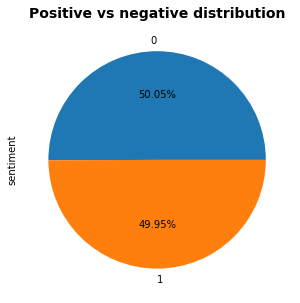

In [ ]:
# Plot pie to check distribution
plt.figure(figsize=(8,5))

df.sentiment.value_counts().plot(kind='pie', autopct='%.2f%%')
plt.title('Positive vs negative distribution',
          fontsize=14, fontweight='bold')
plt.show()

***Observations***<br>
- The target classes are balanced.

Let's look at number of word within positive and negative tweets, to see if there are differences.

Positive tweets lenght - min :1, max :64, mean :13.0
Negative tweets lenght - min :1, max :57, mean :14.0




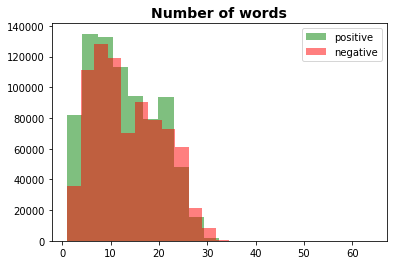

In [ ]:
negative_tweet = df[df.sentiment == 0]
positive_tweet = df[df.sentiment == 1]

neg_lenght = negative_tweet.tweet.str.split().str.len()
pos_lenght = positive_tweet.tweet.str.split().str.len()

print('Positive tweets lenght - min :{}, max :{}, mean :{}'.format(pos_lenght.min(),
                                                                   pos_lenght.max(),
                                                                   round(pos_lenght.mean(),0)))
print('Negative tweets lenght - min :{}, max :{}, mean :{}'.format(neg_lenght.min(),
                                                                   neg_lenght.max(),
                                                                   round(neg_lenght.mean(),0)))
print('\n')

plt.figure()
plt.hist(pos_lenght, bins=20, label='positive', color='g', alpha=0.5)
plt.hist(neg_lenght, bins=20, label='negative', color='r', alpha=0.5)
plt.title('Number of words', fontsize=14, fontweight='bold')
plt.legend()
plt.show()

***Observations***:
- Not much difference in number of words used in tweets; maybe because of tweet length limitation;
- Without any text cleaning, the maximum number of words is 64.

### <font color=blue>P1.1.2 - Check of USER feature</font>

Here, we quickly check if we find specificities among **Negative vs Positive mood** users.

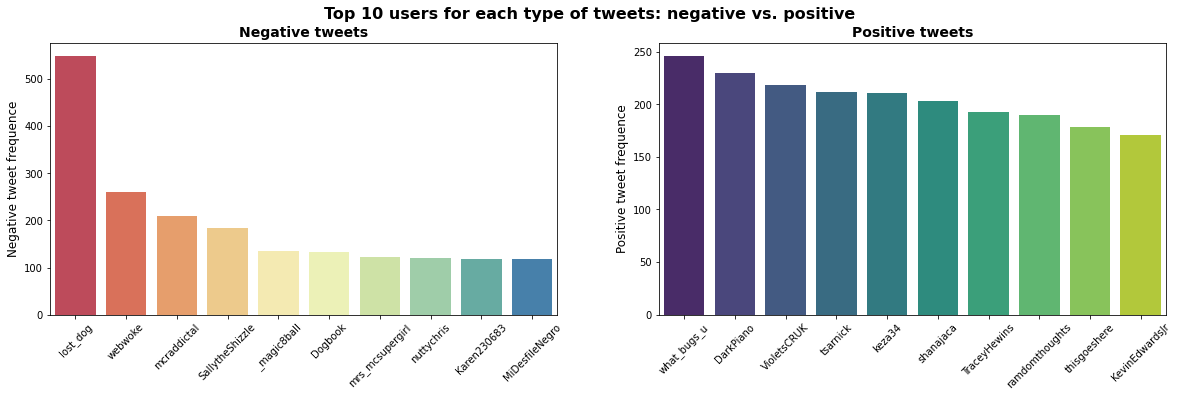

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))

negative_keywords = sns.barplot(x=negative_tweet.user.value_counts()[:10].index,
                                y=negative_tweet.user.value_counts()[:10],
                                palette='Spectral',
                                ax=ax1)
negative_keywords.set_xticklabels(negative_keywords.get_xticklabels(),
                                  rotation=45)
negative_keywords.set_ylabel('Negative tweet frequence', fontsize=12)
ax1.set_title('Negative tweets', fontsize=14, fontweight='bold')

positive_keywords = sns.barplot(x=positive_tweet.user.value_counts()[:10].index,
                                y=positive_tweet.user.value_counts()[:10],
                                palette='viridis',
                                ax=ax2)
positive_keywords.set_xticklabels(positive_keywords.get_xticklabels(),
                                  rotation=45)
positive_keywords.set_ylabel('Positive tweet frequence', fontsize=12)
ax2.set_title('Positive tweets', fontsize=14, fontweight='bold')
plt.suptitle('Top 10 users for each type of tweets: negative vs. positive',
             fontsize=16, fontweight='bold')
plt.show()

Here we retrieve our "lost_dog" user.

Let's have a look of the top 3 of users for each mood (negative vs positive).

#### Negative mood users

In [ ]:
print('N°1 NEGATIVE MOOD')
print(negative_tweet[negative_tweet.user == 'lost_dog'].shape)
negative_tweet[negative_tweet.user == 'lost_dog'].head(5)

N°1 NEGATIVE MOOD
(549, 3)


,sentiment,user,tweet
43935,0,lost_dog,@NyleW I am lost. Please help me find a good home.
45574,0,lost_dog,@SallyD I am lost. Please help me find a good home.
46919,0,lost_dog,@zuppaholic I am lost. Please help me find a good home.
47949,0,lost_dog,@LOSTPETUSA I am lost. Please help me find a good home.
50572,0,lost_dog,@JeanLevertHood I am lost. Please help me find a good home.


Weird! Same strange message addressed to multiple users.

In [ ]:
print('N°2 NEGATIVE MOOD')
print(negative_tweet[negative_tweet.user == 'webwoke'].shape)
negative_tweet[negative_tweet.user == 'webwoke'].head(5)

N°2 NEGATIVE MOOD
(260, 3)


,sentiment,user,tweet
363303,0,webwoke,"auchh, drop by 1 (32)elitestv.com"
366529,0,webwoke,"auchh, drop by 1 (7)pedeee.com"
366530,0,webwoke,"auchh, drop by 1 (17)rumahabi.com"
366597,0,webwoke,"auchh, drop by 1 (18)twitter.com"
366599,0,webwoke,"auchh, drop by 1 (19)yehia.org"


This one is strange too.

In [ ]:
print('N°3 NEGATIVE MOOD')
print(negative_tweet[negative_tweet.user == 'mcraddictal'].shape)
negative_tweet[negative_tweet.user == 'mcraddictal'].head(5)

N°3 NEGATIVE MOOD
(209, 3)


,sentiment,user,tweet
78963,0,mcraddictal,@mcr_chick i wanna sleep.lol. Urgh. I feel like crying
80895,0,mcraddictal,@mcrfash1 oh no! I'm sorry! I have to go to warped alone
81390,0,mcraddictal,"@MCRIsAPleasure yes, very but i'll stay up a little while longer. It's 12:40am you're right. Lol"
87542,0,mcraddictal,@AmberConfusion it's just a phase...
88435,0,mcraddictal,@MyCheMicALmuse i'm sorry hun. are you still gonna take the classes?


Seems normal.

#### Positive mood users

In [ ]:
print('N°1 POSITIVE MOOD')
print(positive_tweet[positive_tweet.user == 'what_bugs_u'].shape)
positive_tweet[positive_tweet.user == 'what_bugs_u'].head(5)

N°1 POSITIVE MOOD
(246, 3)


,sentiment,user,tweet
1141441,1,what_bugs_u,"@JadeMcCray why limit your story to 140 chr. Tell all what is annoying you at www.iamsoannoyed.com ,it will help relieve your stress"
1141626,1,what_bugs_u,"@cadmiumcannibal why limit your story to 140 ch. Tell all what is annoying you at www.iamsoannoyed.com ,it will help relieve your stress"
1141648,1,what_bugs_u,"@RonanDosSantos why limit your story to 140 chr. Tell all what is annoying you at www.iamsoannoyed.com ,it will help relieve your stress"
1141674,1,what_bugs_u,"@ShayMac28 why limit your story to 140 chr. Tell all what is annoying you at www.iamsoannoyed.com ,it will help relieve your stress"
1142667,1,what_bugs_u,"@lynnsdecor why limit your story to 140 chr. Tell all what is annoying you at www.iamsoannoyed.com ,it will help relieve your stress"


Same pattern as 1st negative mood user, maybe a bot...

In [ ]:
print('N°2 POSITIVE MOOD')
print(positive_tweet[positive_tweet.user == 'DarkPiano'].shape)
positive_tweet[positive_tweet.user == 'DarkPiano'].head(5)

N°2 POSITIVE MOOD
(230, 3)


,sentiment,user,tweet
806955,1,DarkPiano,"@suesshirtshop Same to you, Sue!"
819909,1,DarkPiano,@YouCanPlayPiano Link?
821696,1,DarkPiano,@LadyMelancon Hey there!
831789,1,DarkPiano,Loren DiGiorgi &quot;Prologue&quot; ? http://twt.fm/62980 A quiet lullabye for your Sunday morning
832252,1,DarkPiano,"@CCGAL Thanks for the support, Janelle!"


In [ ]:
print('N°3 POSITIVE MOOD')
print(positive_tweet[positive_tweet.user == 'VioletsCRUK'].shape)
positive_tweet[positive_tweet.user == 'VioletsCRUK'].head(5)

N°3 POSITIVE MOOD
(218, 3)


,sentiment,user,tweet
803380,1,VioletsCRUK,Morning all! Hope you have a good one
806065,1,VioletsCRUK,@ewaninbelfast Morning! Enjoy yoiur day off
816759,1,VioletsCRUK,"@leonkay Lol - just got your comment there! Trampoline is fine, nt yet fallen 2 bits! I have been bouncing on it all day! What you up to?"
817282,1,VioletsCRUK,@leonkay Ha! I like it...very cool...shame about the straw right enough! Lol Catch ya later.
828814,1,VioletsCRUK,@leonkay Morning...nice hat!


USER feature was interesting to analyze because it helps us find some patterns in tweets text that we will have to handle in cleaning step:
- users mention;
- urls and hyperlinks;
- **repetitive messages**;
- tracking human account vs bot account...

During pre-processing phase, keeping users information can help to properly drop the possible duplicates thus, for now, we keep this feature.

### <font color=blue>P1.1.3 - Check HASHTAGS in tweet</font>

Let's have a look at hashtags in the corpus of tweets to decide if we can consider them as essential to detect sentiments.

In [ ]:
# Create function to extract hashtag
def extract_hashtag(text):
    pattern = r'#\S+'
    text = text.lower()
    hashtag_list = re.findall(pattern, text)
    for hashtag in hashtag_list:
        return hashtag

# Call the function
df['hashtag'] = df['tweet'].apply(extract_hashtag)
df.head()

,sentiment,user,tweet,hashtag
0,0,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",None
1,0,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,None
2,0,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,None
3,0,ElleCTF,my whole body feels itchy and like its on fire,None
4,0,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",None


In [ ]:
# Create a list of hashtag
hashtag_words = df['hashtag'].values.tolist()

# Count each unique hashtag
hashtag_count = Counter(hashtag_words)
print('Number of hashtags: ', len(hashtag_count))

# Display the 30 most common hashtag
hashtag_count.most_common(30)

Number of hashtags:  12110


[(None, 1558724),
 ('#followfriday', 2214),
 ('#fb', 1706),
 ('#squarespace', 822),
 ('#ff', 774),
 ('#iranelection', 432),
 ('#musicmonday', 386),
 ('#1', 374),
 ('#asot400', 323),
 ('#iremember', 284),
 ('#myweakness', 258),
 ('#iphone', 244),
 ('#fail', 238),
 ('#f1', 234),
 ('#bgt', 231),
 ('#e3', 218),
 ('#bsb', 213),
 ('#2', 188),
 ('#inaperfectworld', 171),
 ('#haveyouever', 165),
 ('#spymaster', 148),
 ('#followfriday!', 139),
 ('#andyhurleyday', 130),
 ('#goodsex', 118),
 ('#tcot', 102),
 ('#dontyouhate', 102),
 ('#mmwanted', 100),
 ('#clothdiapers', 100),
 ('#hhrs', 95),
 ('#xboxe3', 94)]

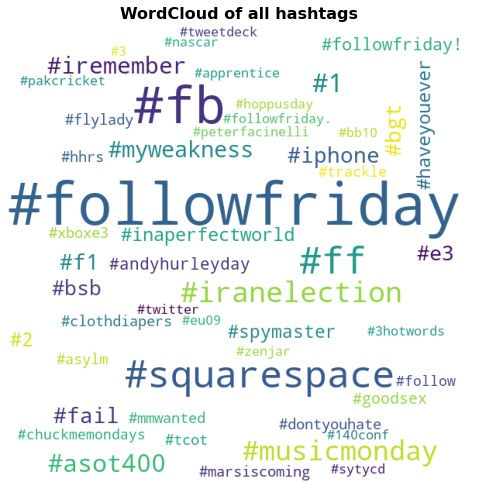

In [ ]:
from wordcloud import WordCloud, STOPWORDS

# Exclude 'None' value
word = hashtag_count.most_common()[1:]

# Instantiate WordCloud
wc = WordCloud(width=600,
               height=600,
               max_words=50,
               background_color="white",
               max_font_size=90)

# Plot WordCloud
plt.figure(figsize= (7, 7))
wc.generate_from_frequencies(dict(word))
plt.imshow(wc)
plt.title('WordCloud of all hashtags',
          fontsize=16, fontweight='bold')
plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# Display the 25 least common hashtag
hashtag_count.most_common()[:-25-1:-1] 

[('#bigrun', 1),
 ('#eric,', 1),
 ('#commtell09', 1),
 ('#blockhh', 1),
 ('#computerarts', 1),
 ('#naseeb', 1),
 ('#brainyday', 1),
 ('#dmdays', 1),
 ('#ffc0cb', 1),
 ('#glastowc', 1),
 ('#mycrack', 1),
 ('#segb', 1),
 ('#freeiran', 1),
 ('#modxer.', 1),
 ('#mrsykes', 1),
 ('#objectivec', 1),
 ('#heweb08', 1),
 ('#kylieminogue', 1),
 ('#knife', 1),
 ('#pletchum', 1),
 ('#wheatgrass:', 1),
 ('#calories', 1),
 ('#securitytwits', 1),
 ('#workcamp', 1),
 ('#quoteclub', 1)]

We can see that the hashtag #followfriday (#ff or #followfriday!) is the most used hashtag, related to the practive of recommanding 2-3 persons on Friday.

But we don't think that these hashtags DO help in showing a specific sentiment. We can then remove them in pre-processing phase, or replace them with the word *hashtag*.

### <font color=blue>P1.1.4 - Save to CSV, ready for pre-processing</font>

In [ ]:
# Display shape and 5 first rows
print(df.shape)
df.head()

(1594745, 4)


,sentiment,user,tweet,hashtag
0,0,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",None
1,0,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,None
2,0,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,None
3,0,ElleCTF,my whole body feels itchy and like its on fire,None
4,0,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",None


Our DataFrame has now **1,594,745** rows and **4** columns.

We can save it for further use.

In [ ]:
# Save to csv file
df.to_csv(src_folder / 'p7_01a_tweet_df.csv', index=False)

# <font color=salmon>PART 2 - TWEETS PRE-PROCESSING</font>

## <font color=green>P2.1 - Import librairies and (re-)load explored DataFrame</font>

In [ ]:
from IPython.display import clear_output

# Install additional library
# https://pypi.org/project/contractions/
!pip install contractions
clear_output()

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import string
import regex
import spacy
import nltk
from nltk.tokenize import TweetTokenizer
import contractions
from nltk.corpus import stopwords
nltk.download('stopwords')

%matplotlib inline

clear_output()

In [ ]:
# General config
# Define main directory
src_folder = Path('/content/drive/MyDrive/OC_IA/P07')

# Set pandas display
pd.set_option("display.max_colwidth", 200)

In [ ]:
# Import dataframe, display 5 first rows
df = pd.read_csv(src_folder / 'p7_01a_tweet_df.csv')
df = df.drop(columns=['hashtag'])
print(df.shape)
df.head()

(1594745, 3)


,sentiment,user,tweet
0,0,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,ElleCTF,my whole body feels itchy and like its on fire
4,0,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


## <font color=green>P2.2 - Run standard preprocessing</font>

In this section, we will create pre-processing series of functions, to clean the tweets and make them more readable. 

We will perform the following steps:
- Normalize text to lower case;
- Correct some spelling errors we have detected;
- Remove (or replace) all user's mentions, urls, hyperlinks, emails and hashtags;
- Remove (or replace) some specific characters;
- Expand all english contractions to keep meaning and especially the word **'not'** which might be essential to detect negative sentiment;
- Remove digits and special characters;
- Remove punctuations;
- Remove white spaces.

### <font color=blue>P2.2.1 - Create a copy of tweet column</font>

Firstly, we create a new column where we can store our pre-processing and compare the result to the original tweets later on.

In [ ]:
# Create new column
df['clean_tweet'] = df['tweet'].copy()

# Display 5 first rows
df.head()

,sentiment,user,tweet,clean_tweet
0,0,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D","@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.","@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


### <font color=blue>P2.2.2 - Apply specific tweet corrections</font>

In [ ]:
# Create tweet/sms dictionary
sms_dict = {'omg':'oh my god', 'gosh':'god', 'its':'it is', 'idk':'i do not know',
            'your welcome':'you are welcome', 'bday':'birthday', ' ur ':' your ', 
            ' til ':' until ', 'shoulda':'should', 'fb':'facebook', 'thx':'thanks'}

# Create pre-processing function
def tweet_preprocessing(text):
    # Convert to lowercase
    text = text.apply(lambda x: ' '.join(x.lower() for x in x.split()))

    # Remove twitter escaped characters (quote, ampersand, acronyms, emoticons..)
    text = text.str.replace('&quot|&amp;|&gt;|&lt;','')
    
    # Remove standard URLs (starting with http, https or www)
    text = text.str.replace(r'http\S+|https\S+| www.\S+', 'url', case=False)

    # Remove other hyperlinks (ending with .com, .org or .net)
    text = text.str.replace(r'\S+\.com|\S+\.org|\S+\.net', 'url', case=False)

    # Replace all users mentions and hashtags
    text = text.str.replace(r'@[\w]*', 'user', case=False)
    text = text.str.replace(r'\#+[\w_]+[\w\'_\-]*[\w_]+', 'hashtag')

    # Remove sms language
    text = text.str.replace('lol|oh |haha|blah|ahh|aww|wow|yeah|yay|hmm|wtf|grr','')

    # Correct sms language
    for key in sms_dict.keys():
        text = text.str.replace(key, sms_dict[key], case=True)
    
    return text

# Call the function
df['clean_tweet'] = tweet_preprocessing(df['clean_tweet'])

# Display 5 first rows
print(df.shape)
df.head()

(1594745, 4)


,sentiment,user,tweet,clean_tweet
0,0,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D","user url - w, that's a bummer. you should got david carr of third day to do it. ;d"
1,0,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,is upset that he can't update his facebook by texting it... and might cry as a result school today also. !
2,0,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,user i dived many times for the ball. managed to save 50% the rest go out of bounds
3,0,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like it is on fire
4,0,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.","user no, it's not behaving at all. i'm mad. why am i here? because i can't see you all over there."


### <font color=blue>P2.2.3 - Correct English contractions</font>

In [ ]:
# Create function to correct contractions
def correct_contraction(text):
    text = contractions.fix(text)
    return text

# Call the function
df['clean_tweet'] = df['clean_tweet'].apply(correct_contraction)
df.head()

,sentiment,user,tweet,clean_tweet
0,0,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D","user url - w, that is a bummer. you should got david carr of third day to do it. ;d"
1,0,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,is upset that he cannot update his facebook by texting it... and might cry as a result school today also. !
2,0,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,user i dived many times for the ball. managed to save 50% the rest go out of bounds
3,0,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like it is on fire
4,0,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.","user no, it is not behaving at all. I am mad. why am i here? because i cannot see you all over there."


### <font color=blue>P2.2.4 - Apply standard text preprocessing</font>

In [ ]:
# Initialize tweet tokenizer
tknzr = TweetTokenizer()

# Create function to remove punctuation
def remove_punctuation(text):
    table = str.maketrans('', '', string.punctuation)
    clean_text = ' '.join([w.translate(table) for w in tknzr.tokenize(text)])
    clean_text = ' '.join(clean_text.split())
    return clean_text

# Create pre-processing function
def text_preprocessing(text):
    # Convert to lowercase
    text = text.apply(lambda x: ' '.join(x.lower() for x in x.split()))
    
    # Replace "-" and " ' " with space
    text = text.str.replace("-|'", ' ')
    
    # Remove numbers and special characters with spaces
    text = text.str.replace(r'[^a-zA-Z\s]', ' ')

    # Remove punctuation
    text = text.apply(remove_punctuation)

    # Remove repeated characters
    text = text.str.replace(r'(.)\1{2}', '')

    # Remove remaining spaces
    text = text.apply(lambda x: ' '.join([w for w in x.split()]))

    return text

# Call the function
df['clean_tweet'] = text_preprocessing(df['clean_tweet'])

# Display 5 first rows
df.head()

,sentiment,user,tweet,clean_tweet
0,0,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",user url w that is a bummer you should got david carr of third day to do it d
1,0,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,is upset that he cannot update his facebook by texting it and might cry as a result school today also
2,0,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,user i dived many times for the ball managed to save the rest go out of bounds
3,0,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like it is on fire
4,0,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",user no it is not behaving at all i am mad why am i here because i cannot see you all over there


### <font color=blue>P2.2.5 - Remove null values and user/tweet duplicates</font>

#### Create columns of word and char counts

In [ ]:
# Create new features: word count / character count
df['word_count'] = df['clean_tweet'].str.split().str.len()
df['char_count'] = df['clean_tweet'].str.len()

# Words metrics
min_word = df.word_count.min()
max_word = df.word_count.max()
mean_word = df.word_count.mean()

# Chars metrics
min_char = df.char_count.min()
max_char = df.char_count.max()
mean_char = df.char_count.mean()

print('Min word: {}, Max word: {}'.format(min_word, max_word, mean_word))
print('Min char: {}, Max char: {}'.format(min_char, max_char, mean_char))

# Display 5 first rows
df.head()

Min word: 0, Max word: 52
Min char: 0, Max char: 201


,sentiment,user,tweet,clean_tweet,word_count,char_count
0,0,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",user url w that is a bummer you should got david carr of third day to do it d,19,77
1,0,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,is upset that he cannot update his facebook by texting it and might cry as a result school today also,20,101
2,0,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,user i dived many times for the ball managed to save the rest go out of bounds,17,78
3,0,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like it is on fire,11,48
4,0,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",user no it is not behaving at all i am mad why am i here because i cannot see you all over there,23,96


Well we can see that some tweets has no word (min=0), no character (min=0). 

#### Remove all tweets with 0 or 1 word

In [ ]:
# Filter with mask on columns values
df = df[(df.word_count > 1)]

# Display shape and 5 first rows
print(df.shape)
df.head()

(1587007, 6)


,sentiment,user,tweet,clean_tweet,word_count,char_count
0,0,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",user url w that is a bummer you should got david carr of third day to do it d,19,77
1,0,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,is upset that he cannot update his facebook by texting it and might cry as a result school today also,20,101
2,0,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,user i dived many times for the ball managed to save the rest go out of bounds,17,78
3,0,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like it is on fire,11,48
4,0,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",user no it is not behaving at all i am mad why am i here because i cannot see you all over there,23,96


#### Remove duplicates

Here we remove the duplicates we have already spot in PART 1.

In [ ]:
# Check subsets duplicates
df.duplicated(subset=['user', 'clean_tweet']).value_counts()

False    1579786
True        7221
dtype: int64

In [ ]:
# Remove duplicates
df.drop_duplicates(subset=['user', 'clean_tweet'], inplace=True)

# Display shape and 5 first rows
print(df.shape)
df.head()

(1579786, 6)


,sentiment,user,tweet,clean_tweet,word_count,char_count
0,0,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",user url w that is a bummer you should got david carr of third day to do it d,19,77
1,0,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,is upset that he cannot update his facebook by texting it and might cry as a result school today also,20,101
2,0,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,user i dived many times for the ball managed to save the rest go out of bounds,17,78
3,0,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like it is on fire,11,48
4,0,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",user no it is not behaving at all i am mad why am i here because i cannot see you all over there,23,96


### <font color=blue>P2.2.6 - Explore result as final check</font>

In [ ]:
# UPDATE OF METRICS
# Words metrics
min_word = df.word_count.min()
max_word = df.word_count.max()
mean_word = df.word_count.mean()

# Chars metrics
min_char = df.char_count.min()
max_char = df.char_count.max()
mean_char = df.char_count.mean()

Min word: 2, Max word: 52
Min char: 4, Max char: 201


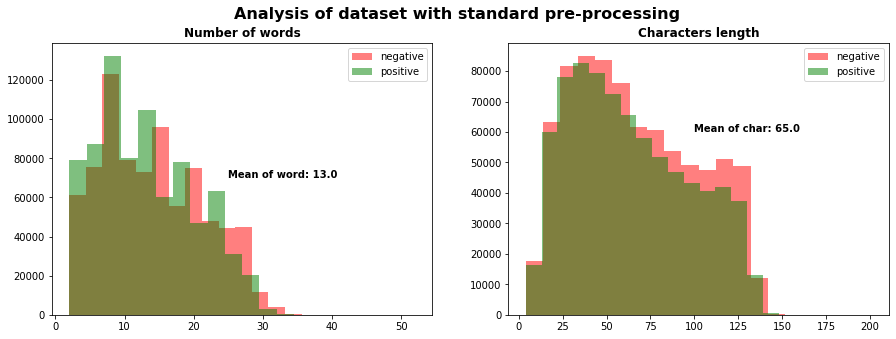

In [ ]:
# Negative and Positive WORD DF
negative_word = df[df.sentiment == 0]
positive_word = df[df.sentiment == 1]

# Prepare plot variables
neg_word_count = negative_word.word_count
pos_word_count = positive_word.word_count
neg_char_length = negative_word.char_count
pos_char_length = positive_word.char_count

print('Min word: {}, Max word: {}'.format(min_word, max_word))
print('Min char: {}, Max char: {}'.format(min_char, max_char))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.hist(neg_word_count, bins=20, label='negative', color='r', alpha=0.5)
ax1.hist(pos_word_count, bins=20, label='positive', color='g', alpha=0.5)
ax1.set_title('Number of words', fontsize=12, fontweight='bold')
message1 = 'Mean of word: {}'.format(round(mean_word, 0))
ax1.text(25, 70000, message1, weight='bold')
ax1.legend()

ax2.hist(neg_char_length, bins=20, label='negative', color='r', alpha=0.5)
ax2.hist(pos_char_length, bins=20, label='positive', color='g', alpha=0.5)
ax2.set_title('Characters length', fontsize=12, fontweight='bold')
message2 = 'Mean of char: {}'.format(round(mean_char, 0))
ax2.text(100, 60000, message2, weight='bold')
ax2.legend()

plt.suptitle('Analysis of dataset with standard pre-processing',
             fontsize=16, fontweight='bold')
plt.show()

## <font color=green>P2.3 - Run advanced preprocessing</font>

In this section, we perform 2 additional pre-processing:
- Remove english stopwords and words with only 1-character;
- And finally, lemmatize (retrieve the root word) to reduce the number of unique words.

### <font color=blue>P2.3.1 - Remove stopwords</font>

In [ ]:
# Drop useless features
df.drop(columns=['char_count'], inplace=True)

# Rename columns
df.rename(columns={'word_count':'clean_w_count'}, inplace=True)
df.head()

,sentiment,user,tweet,clean_tweet,clean_w_count
0,0,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",user url w that is a bummer you should got david carr of third day to do it d,19
1,0,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,is upset that he cannot update his facebook by texting it and might cry as a result school today also,20
2,0,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,user i dived many times for the ball managed to save the rest go out of bounds,17
3,0,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like it is on fire,11
4,0,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",user no it is not behaving at all i am mad why am i here because i cannot see you all over there,23


In [ ]:
# Create stop_words and extend/remove some words
stop_words = stopwords.words('english')
stop_words.extend(["could", "might", "should", "us", "would",
                   "bit"])
stop_words.remove("not")
stop_words.remove("no")

# Display for check
', '.join(stop_words)

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, nor, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mustn't, nee

In [ ]:
# Create stopwords removal function
def remove_stopwords(text):
    clean_text=' '.join([w for w in text.split() if w not in stop_words])
    return clean_text

# Create pre-processing function
def stops_preprocessing(text):  
    # Remove stopwords
    text = text.apply(lambda text: remove_stopwords(text))

    # Remove remaining spaces
    text = text.apply(lambda x: ' '.join([w for w in x.split() if len(w) > 1]))

    return text

# Call the function
df['noStop_tweet'] = stops_preprocessing(df['clean_tweet'])

# Display 5 first rows
print(df.shape)
df.head()

(1579786, 6)


,sentiment,user,tweet,clean_tweet,clean_w_count,noStop_tweet
0,0,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",user url w that is a bummer you should got david carr of third day to do it d,19,user url bummer got david carr third day
1,0,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,is upset that he cannot update his facebook by texting it and might cry as a result school today also,20,upset cannot update facebook texting cry result school today also
2,0,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,user i dived many times for the ball managed to save the rest go out of bounds,17,user dived many times ball managed save rest go bounds
3,0,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like it is on fire,11,whole body feels itchy like fire
4,0,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",user no it is not behaving at all i am mad why am i here because i cannot see you all over there,23,user no not behaving mad cannot see


### <font color=blue>P2.3.2 - Stemming & Lemmatize</font>

Lemmatization is the concept of reducing down a word to its nearest root word; i.e. removing the prefixes and suffices and replacing with the nearest word of that form. i.e. for checking --> check , girls --> girl etc.

The stem need not be a word, for example the Porter algorithm reduces, argue, argued, argues, arguing, and argus to the stem argu

In [ ]:
from IPython.display import clear_output
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')

clear_output()

In [ ]:
# Instantiate the Stemmer & lemmatizer
pstemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def stem(text):
    text = ' '.join([pstemmer.stem(doc) for doc in text.split()])
    return text

def lemmatize(text):
    text = ' '.join([lemmatizer.lemmatize(doc) for doc in text.split()])
    return text

# Call the function
df['lemma_tweet'] = df['noStop_tweet'].apply(lambda x: lemmatize(x))
df['stem_tweet'] = df['noStop_tweet'].apply(lambda x: stem(x))

# Display 5 first rows
print(df.shape)
df.head(20)

(1579786, 8)


,sentiment,user,tweet,clean_tweet,clean_w_count,noStop_tweet,lemma_tweet,stem_tweet
0,0,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",user url w that is a bummer you should got david carr of third day to do it d,19,user url bummer got david carr third day,user url bummer got david carr third day,user url bummer got david carr third day
1,0,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,is upset that he cannot update his facebook by texting it and might cry as a result school today also,20,upset cannot update facebook texting cry result school today also,upset cannot update facebook texting cry result school today also,upset cannot updat facebook text cri result school today also
2,0,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,user i dived many times for the ball managed to save the rest go out of bounds,17,user dived many times ball managed save rest go bounds,user dived many time ball managed save rest go bound,user dive mani time ball manag save rest go bound
3,0,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like it is on fire,11,whole body feels itchy like fire,whole body feel itchy like fire,whole bodi feel itchi like fire
4,0,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",user no it is not behaving at all i am mad why am i here because i cannot see you all over there,23,user no not behaving mad cannot see,user no not behaving mad cannot see,user no not behav mad cannot see
5,0,joy_wolf,@Kwesidei not the whole crew,user not the whole crew,5,user not whole crew,user not whole crew,user not whole crew
6,0,mybirch,Need a hug,need a hug,3,need hug,need hug,need hug
7,0,coZZ,"@LOLTrish hey long time no see! Yes.. Rains a bit ,only a bit LOL , I'm fine thanks , how's you ?",user hey long time no see yes rains a bit only a bit i am fine thanks how is you,20,user hey long time no see yes rains fine thanks,user hey long time no see yes rain fine thanks,user hey long time no see ye rain fine thank
8,0,2Hood4Hollywood,@Tatiana_K nope they didn't have it,user nope they did not have it,7,user nope not,user nope not,user nope not
9,0,mimismo,@twittera que me muera ?,user que me muera,4,user que muera,user que muera,user que muera


### <font color=blue>P2.3.2 - Remove null values and user/tweet duplicates</font>

#### Create columns of word and char counts

In [ ]:
# Create new features: word count / character count
df['lemma_word_count'] = df['lemma_tweet'].str.split().str.len()
df['lemma_char_count'] = df['lemma_tweet'].str.len()

# Words metrics
lemma_min_word = df.lemma_word_count.min()
lemma_max_word = df.lemma_word_count.max()
lemma_mean_word = df.lemma_word_count.mean()

# Chars metrics
lemma_min_char = df.lemma_char_count.min()
lemma_max_char = df.lemma_char_count.max()
lemma_mean_char = df.lemma_char_count.mean()

print('lemma Min word: {}, lemma Max word: {}, lemma Mean word: {}'.format(lemma_min_word, lemma_max_word, lemma_mean_word))
print('lemma Min char: {}, lemma Max char: {}, lemma Mean char: {}'.format(lemma_min_char, lemma_max_char, lemma_mean_char))

# Create new features: word count / character count
df['stem_word_count'] = df['stem_tweet'].str.split().str.len()
df['stem_char_count'] = df['stem_tweet'].str.len()

# Words metrics
stem_min_word = df.stem_word_count.min()
stem_max_word = df.stem_word_count.max()
stem_mean_word = df.stem_word_count.mean()

# Chars metrics
stem_min_char = df.stem_char_count.min()
stem_max_char = df.stem_char_count.max()
stem_mean_char = df.stem_char_count.mean()

print('stem Min word: {}, stem Max word: {}, stem Mean word: {}'.format(stem_min_word, stem_max_word, stem_mean_word))
print('stem Min char: {}, stem Max char: {}, stem Mean char: {}'.format(stem_min_char, stem_max_char, stem_mean_char))

# Display 5 first rows
df.head()

lemma Min word: 0, lemma Max word: 34, lemma Mean word: 7.322509504451869
lemma Min char: 0, lemma Max char: 198, lemma Mean char: 42.551989320072465
stem Min word: 0, stem Max word: 34, stem Mean word: 7.322509504451869
stem Min char: 0, stem Max char: 198, stem Mean char: 39.41791673049388


,sentiment,user,tweet,clean_tweet,clean_w_count,noStop_tweet,lemma_tweet,stem_tweet,lemma_word_count,lemma_char_count,stem_word_count,stem_char_count
0,0,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",user url w that is a bummer you should got david carr of third day to do it d,19,user url bummer got david carr third day,user url bummer got david carr third day,user url bummer got david carr third day,8,40,8,40
1,0,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,is upset that he cannot update his facebook by texting it and might cry as a result school today also,20,upset cannot update facebook texting cry result school today also,upset cannot update facebook texting cry result school today also,upset cannot updat facebook text cri result school today also,10,65,10,61
2,0,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,user i dived many times for the ball managed to save the rest go out of bounds,17,user dived many times ball managed save rest go bounds,user dived many time ball managed save rest go bound,user dive mani time ball manag save rest go bound,10,52,10,49
3,0,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like it is on fire,11,whole body feels itchy like fire,whole body feel itchy like fire,whole bodi feel itchi like fire,6,31,6,31
4,0,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",user no it is not behaving at all i am mad why am i here because i cannot see you all over there,23,user no not behaving mad cannot see,user no not behaving mad cannot see,user no not behav mad cannot see,7,35,7,32


#### Remove all tweets with 0 or 1 word

In [ ]:
# Filter with mask on columns values
df = df[(df.stem_word_count > 1)]

# Display shape and 5 first rows
print(df.shape)
df.head()

(1561338, 12)


,sentiment,user,tweet,clean_tweet,clean_w_count,noStop_tweet,lemma_tweet,stem_tweet,lemma_word_count,lemma_char_count,stem_word_count,stem_char_count
0,0,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",user url w that is a bummer you should got david carr of third day to do it d,19,user url bummer got david carr third day,user url bummer got david carr third day,user url bummer got david carr third day,8,40,8,40
1,0,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,is upset that he cannot update his facebook by texting it and might cry as a result school today also,20,upset cannot update facebook texting cry result school today also,upset cannot update facebook texting cry result school today also,upset cannot updat facebook text cri result school today also,10,65,10,61
2,0,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,user i dived many times for the ball managed to save the rest go out of bounds,17,user dived many times ball managed save rest go bounds,user dived many time ball managed save rest go bound,user dive mani time ball manag save rest go bound,10,52,10,49
3,0,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like it is on fire,11,whole body feels itchy like fire,whole body feel itchy like fire,whole bodi feel itchi like fire,6,31,6,31
4,0,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",user no it is not behaving at all i am mad why am i here because i cannot see you all over there,23,user no not behaving mad cannot see,user no not behaving mad cannot see,user no not behav mad cannot see,7,35,7,32


#### Remove duplicates

In [ ]:
# Check subsets duplicates
df.duplicated(subset=['user', 'lemma_tweet']).value_counts()

False    1559839
True        1499
dtype: int64

In [ ]:
# Remove duplicates
df.drop_duplicates(subset=['user', 'lemma_tweet'], inplace=True)

# Display shape and 5 first rows
print(df.shape)
df.head()

(1559839, 12)


,sentiment,user,tweet,clean_tweet,clean_w_count,noStop_tweet,lemma_tweet,stem_tweet,lemma_word_count,lemma_char_count,stem_word_count,stem_char_count
0,0,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",user url w that is a bummer you should got david carr of third day to do it d,19,user url bummer got david carr third day,user url bummer got david carr third day,user url bummer got david carr third day,8,40,8,40
1,0,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,is upset that he cannot update his facebook by texting it and might cry as a result school today also,20,upset cannot update facebook texting cry result school today also,upset cannot update facebook texting cry result school today also,upset cannot updat facebook text cri result school today also,10,65,10,61
2,0,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,user i dived many times for the ball managed to save the rest go out of bounds,17,user dived many times ball managed save rest go bounds,user dived many time ball managed save rest go bound,user dive mani time ball manag save rest go bound,10,52,10,49
3,0,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like it is on fire,11,whole body feels itchy like fire,whole body feel itchy like fire,whole bodi feel itchi like fire,6,31,6,31
4,0,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",user no it is not behaving at all i am mad why am i here because i cannot see you all over there,23,user no not behaving mad cannot see,user no not behaving mad cannot see,user no not behav mad cannot see,7,35,7,32


### <font color=blue>P2.3.3 - Explore result as final check</font>

In [ ]:
# UPDATE OF METRICS
# Words metrics
min_word = df.lemma_word_count.min()
max_word = df.lemma_word_count.max()
mean_word = df.lemma_word_count.mean()

# Chars metrics
min_char = df.lemma_char_count.min()
max_char = df.lemma_char_count.max()
mean_char = df.lemma_char_count.mean()

Min word: 2, Max word: 34
Min char: 3, Max char: 198


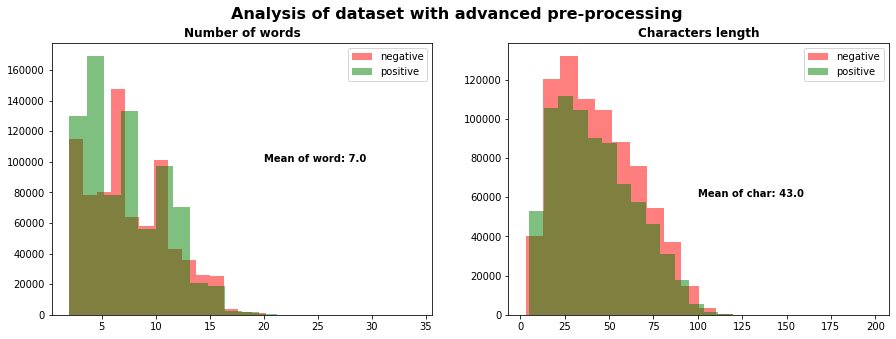

In [ ]:
# Negative and Positive WORD DF
negative_word = df[df.sentiment == 0]
positive_word = df[df.sentiment == 1]

# Prepare plot variables
neg_word_count = negative_word.lemma_word_count
pos_word_count = positive_word.lemma_word_count
neg_char_length = negative_word.lemma_char_count
pos_char_length = positive_word.lemma_char_count

print('Min word: {}, Max word: {}'.format(min_word, max_word))
print('Min char: {}, Max char: {}'.format(min_char, max_char))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.hist(neg_word_count, bins=20, label='negative', color='r', alpha=0.5)
ax1.hist(pos_word_count, bins=20, label='positive', color='g', alpha=0.5)
ax1.set_title('Number of words', fontsize=12, fontweight='bold')
message1 = 'Mean of word: {}'.format(round(mean_word, 0))
ax1.text(20, 100000, message1, weight='bold')
ax1.legend()

ax2.hist(neg_char_length, bins=20, label='negative', color='r', alpha=0.5)
ax2.hist(pos_char_length, bins=20, label='positive', color='g', alpha=0.5)
ax2.set_title('Characters length', fontsize=12, fontweight='bold')
message2 = 'Mean of char: {}'.format(round(mean_char, 0))
ax2.text(100, 60000, message2, weight='bold')
ax2.legend()

plt.suptitle('Analysis of dataset with advanced pre-processing',
             fontsize=16, fontweight='bold')
plt.show()

In [ ]:
# Drop useless features
df.drop(columns=['lemma_char_count', 'stem_char_count'], inplace=True)

# Rename columns
df.rename(columns={'lemma_word_count':'lemma_w_count'}, inplace=True)
df.rename(columns={'stem_word_count':'stem_w_count'}, inplace=True)
df.head()

,sentiment,user,tweet,clean_tweet,clean_w_count,noStop_tweet,lemma_tweet,stem_tweet,lemma_w_count,stem_w_count
0,0,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",user url w that is a bummer you should got david carr of third day to do it d,19,user url bummer got david carr third day,user url bummer got david carr third day,user url bummer got david carr third day,8,8
1,0,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,is upset that he cannot update his facebook by texting it and might cry as a result school today also,20,upset cannot update facebook texting cry result school today also,upset cannot update facebook texting cry result school today also,upset cannot updat facebook text cri result school today also,10,10
2,0,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,user i dived many times for the ball managed to save the rest go out of bounds,17,user dived many times ball managed save rest go bounds,user dived many time ball managed save rest go bound,user dive mani time ball manag save rest go bound,10,10
3,0,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like it is on fire,11,whole body feels itchy like fire,whole body feel itchy like fire,whole bodi feel itchi like fire,6,6
4,0,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",user no it is not behaving at all i am mad why am i here because i cannot see you all over there,23,user no not behaving mad cannot see,user no not behaving mad cannot see,user no not behav mad cannot see,7,7


### <font color=blue>P2.3.4 - Save data version</font>

In [ ]:
# Save to csv file
df.to_csv(src_folder / 'p7_01b_final_df.csv', index=False)

# <font color=salmon>PART 3 - DATA VISUALIZATION</font>

In [ ]:
# Import libraries
import pandas as pd
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

%matplotlib inline

# Set general config
pd.set_option("display.max_colwidth", 200)
src_folder = Path('/content/drive/MyDrive/OC_IA/P07')

In [ ]:
# (re)Load DF
df = pd.read_csv(src_folder / 'p7_01b_final_df.csv')
df.head()

,sentiment,user,tweet,clean_tweet,clean_w_count,noStop_tweet,lemma_tweet,stem_tweet,lemma_w_count,stem_w_count
0,0,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",user url w that is a bummer you should got david carr of third day to do it d,19,user url bummer got david carr third day,user url bummer got david carr third day,user url bummer got david carr third day,8,8
1,0,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,is upset that he cannot update his facebook by texting it and might cry as a result school today also,20,upset cannot update facebook texting cry result school today also,upset cannot update facebook texting cry result school today also,upset cannot updat facebook text cri result school today also,10,10
2,0,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,user i dived many times for the ball managed to save the rest go out of bounds,17,user dived many times ball managed save rest go bounds,user dived many time ball managed save rest go bound,user dive mani time ball manag save rest go bound,10,10
3,0,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like it is on fire,11,whole body feels itchy like fire,whole body feel itchy like fire,whole bodi feel itchi like fire,6,6
4,0,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",user no it is not behaving at all i am mad why am i here because i cannot see you all over there,23,user no not behaving mad cannot see,user no not behaving mad cannot see,user no not behav mad cannot see,7,7


## <font color=green>P3.1 - Check sentiment distribution</font>

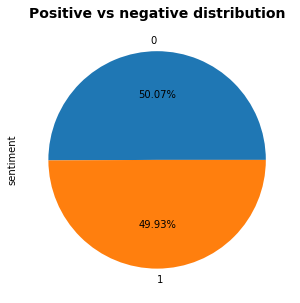

In [ ]:
# Plot pie to check distribution
plt.figure(figsize=(8,5))

df.sentiment.value_counts().plot(kind='pie',
                                 autopct='%.2f%%')
plt.title('Positive vs negative distribution',
          fontsize=14, fontweight='bold')
plt.show()

## <font color=green>P3.2 - Visualize tweets words with WordCloud</font>

In [ ]:
# Negative and Positive WORD DFs
negative_word = df[df.sentiment == 0]
positive_word = df[df.sentiment == 1]

# Print shapes
print('Negative tweets shape: ', negative_word.shape)
print('Positive tweets shape: ', positive_word.shape)

Negative tweets shape:  (781019, 10)
Positive tweets shape:  (778820, 10)


### <font color=blue>P3.2.1 - Tweet with StopWords</font>

In [ ]:
text_all = str(df['clean_tweet'].values)
text_neg = str(negative_word['clean_tweet'].values)
text_pos = str(positive_word['clean_tweet'].values)

# Instantiate WordCloud
wc_all = WordCloud(width=600, height=600, background_color="white",
                   max_words=200, stopwords=STOPWORDS, max_font_size=90,
                   collocations=False, random_state=42).generate(text_all)

wc_neg = WordCloud(width=600, height=600, background_color="white",
                   max_words=200, stopwords=STOPWORDS, max_font_size=90,
                   collocations=False, random_state=42).generate(text_neg)

wc_pos = WordCloud(width=600, height=600, background_color="white",
                   max_words=200, stopwords=STOPWORDS, max_font_size=90,
                   collocations=False, random_state=42).generate(text_pos)

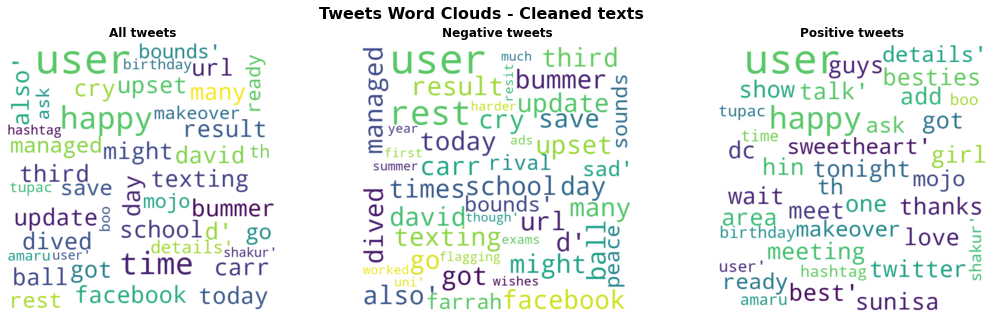

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

ax1.imshow(wc_all, interpolation='bilinear')
ax1.set_title('All tweets', fontsize=12, fontweight='bold')
ax1.axis('off')

ax2.imshow(wc_neg, interpolation='bilinear')
ax2.set_title('Negative tweets', fontsize=12, fontweight='bold')
ax2.axis('off')

ax3.imshow(wc_pos, interpolation='bilinear')
ax3.set_title('Positive tweets', fontsize=12, fontweight='bold')
ax3.axis('off')

plt.suptitle('Tweets Word Clouds - Cleaned texts', fontsize=16, fontweight='bold')
plt.show()

### <font color=blue>P3.2.2 - Lemmatized tweet</font>

In [ ]:
text_all = str(df['lemma_tweet'].values)
text_neg = str(negative_word['lemma_tweet'].values)
text_pos = str(positive_word['lemma_tweet'].values)

# Instantiate WordCloud
wc_all = WordCloud(width=600, height=600, background_color="white",
                   max_words=200, stopwords=STOPWORDS, max_font_size=90,
                   collocations=False, random_state=42).generate(text_all)

wc_neg = WordCloud(width=600, height=600, background_color="white",
                   max_words=200, stopwords=STOPWORDS, max_font_size=90,
                   collocations=False, random_state=42).generate(text_neg)

wc_pos = WordCloud(width=600, height=600, background_color="white",
                   max_words=200, stopwords=STOPWORDS, max_font_size=90,
                   collocations=False, random_state=42).generate(text_pos)

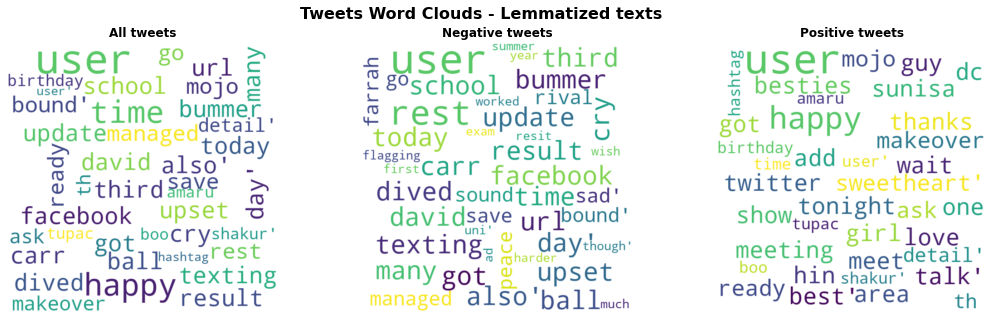

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

ax1.imshow(wc_all, interpolation='bilinear')
ax1.set_title('All tweets', fontsize=12, fontweight='bold')
ax1.axis('off')

ax2.imshow(wc_neg, interpolation='bilinear')
ax2.set_title('Negative tweets', fontsize=12, fontweight='bold')
ax2.axis('off')

ax3.imshow(wc_pos, interpolation='bilinear')
ax3.set_title('Positive tweets', fontsize=12, fontweight='bold')
ax3.axis('off')

plt.suptitle('Tweets Word Clouds - Lemmatized texts', fontsize=16, fontweight='bold')
plt.show()

## <font color=green>P3.3 - Check word frequencies</font>

### <font color=blue>P3.3.1 - Tweet with StopWords</font>

In [ ]:
# Create empty list of string
words = ''

# Append each string
for i in df.clean_tweet.values:
    words += i
print('Number of words', len(words))

# Save in a Dataframe
wd = pd.DataFrame(Counter(words.split()).most_common(50), columns=['word', 'frequency'])
wd[:10]

Number of words 102265211


,word,frequency
0,i,882368
1,to,607771
2,the,507549
3,is,392754
4,a,376014
5,you,323966
6,it,302228
7,and,297009
8,my,290312
9,not,275477


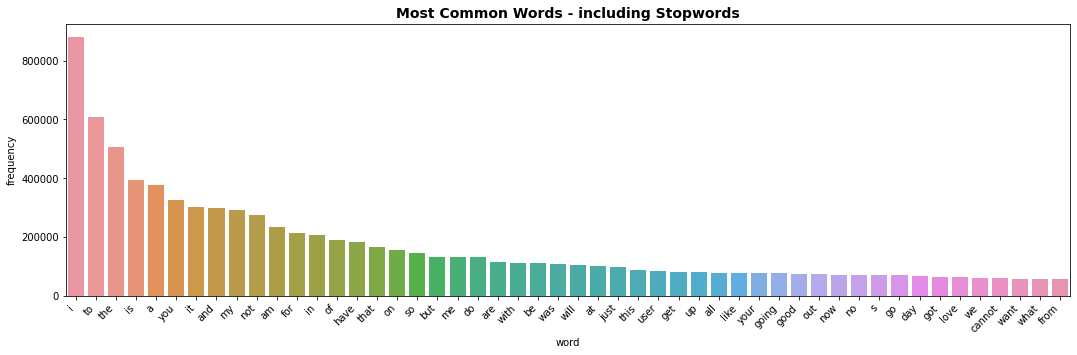

In [ ]:
# Plot word frequencies
plt.figure(figsize=(18, 5))
sns.barplot(x=wd.word, y=wd.frequency)
plt.xticks(rotation=45, ha='right')
plt.title('Most Common Words - including Stopwords', fontsize=14, fontweight='bold')
plt.show()

We can see that we have very uninformative words like *to, it, my, of, in,..*: "*I*" has more than 800k occurences!

We should use the lemmatized texts, excluding Stopwords for our modeling.

### <font color=blue>P3.3.2 - Lemmatized tweet</font>

In [ ]:
# Create empty list of string
words = ''

# Append each string
for i in df.lemma_tweet.values:
    words += i
print('Number of words', len(words))

# Save in a Dataframe
wd = pd.DataFrame(Counter(words.split()).most_common(50), columns=['word', 'frequency'])
wd[:10]

Number of words 67033666


,word,frequency
0,not,251861
1,user,82920
2,get,78443
3,day,77866
4,like,70839
5,good,69628
6,no,67953
7,go,67884
8,going,67259
9,cannot,53225


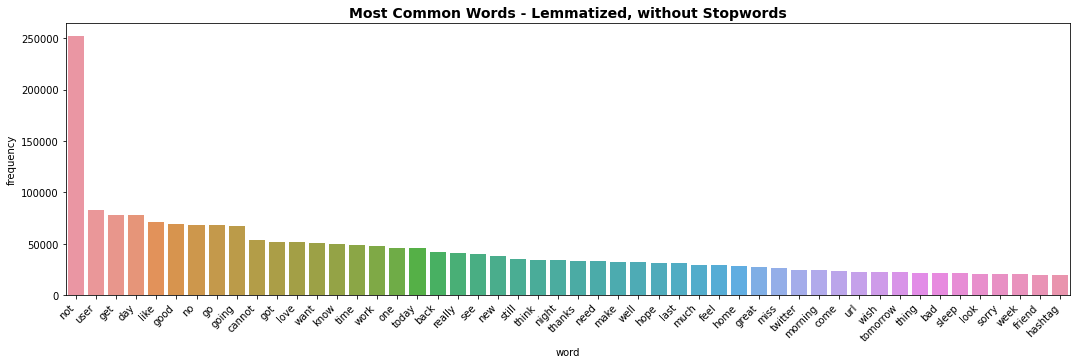

In [ ]:
# Plot word frequencies
plt.figure(figsize=(18, 5))
sns.barplot(x=wd.word, y=wd.frequency)
plt.xticks(rotation=45, ha='right')
plt.title('Most Common Words - Lemmatized, without Stopwords', fontsize=14, fontweight='bold')
plt.show()

# <font color=salmon>CONCLUSION</font>

We have now prepared our tweet text to be enough clean to facilitate its use in a Machine Learning algorithm.

Some points could have been improved:
- exclude all rows which are not in english: we have found spanish or unknown language, but we were unable to track/exclude them;
- split / segment words in hashtag: like #charitytuesday to be converted into *charity tuesday*, but we didn't find maintained library which can help;

However, **our dataset is ready for NLP modeling**.